# PRAD : Analysis between risk-groups 

# Introduction

We will find the differentially expressed genes between predicted high and low risk groups. 

# Preparing workspace

In [1]:
setwd("/home/data/project_code/landstrom_core/prognostic_model_development/r/notebooks")

library(ggplot2)
library(tidyverse)
library(survival)
library(survminer)
library(glmnet)
library(WriteXLS)
library(ggfortify)
library(circlize)
library(ComplexHeatmap)
library(parallel)
library(broom)
library(survcomp)
library(survivalROC)
source("../getTCGAData.R")
source("../preprocessTCGAData.R")
source("../KM_analysis.R")
source("../Heatmaps.R")
source("../enet.R")

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-4

circlize version 0.4.14
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.i

# Setting up paths and clinical variables

In [2]:
# Define the cancer type 
cancer.type = "PRAD"

In [3]:
# Read in the table including the clinical features for each cancer type
clin.feat.tb = read.table("/workstation/project_data/landstrom_core/clin_features_final.csv", sep = "\t", header = T)

# Get Clinical variables
clin.var = unlist(strsplit(clin.feat.tb$Features[clin.feat.tb$Ctype == cancer.type], split = ","))

# Ensembl id mapping file 
ens.id.mapping = "/home/organisms/Human/hg38/Homo_sapiens.GRCh38_March2022/ENSEMBLE_to_SYMBOL.csv"

# Output dir 
out.dir.data = file.path("/workstation/project_data/landstrom_core/rdata/manuscript_work/", cancer.type)
dir.create(out.dir.data, recursive = T)

Warning message in dir.create(out.dir.data, recursive = T):
“'/workstation/project_data/landstrom_core/rdata/manuscript_work//PRAD' already exists”


# 1. KM based univariate feature selection

We will now perform the univariate feature selection which is the first phase of 
the actual analysis. The idea is to prefilter some features which have no predictive 
power regarding survival. We will select one clinical end point which seems to carry 
most events to maximise the statistical power. 

## 1.1 Loading data and selection of variables 

Load the dataset if needed

In [5]:
# Read in the preprocessed dataset if continued 
tcga.dataset = readRDS(file.path(out.dir.data, "tcga.dataset.rds"))

# Raw expression data 
tcga.expr.raw.datamat = readRDS(file.path(out.dir.data, "raw_expressions.rds"))

Define and create output directories 

In [6]:
# Define and create the root directory for results 
dir.res.root = file.path("/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk", cancer.type)
dir.create(dir.res.root, recursive = T)

# Define and create the results for the KM analysis 
dir.res.km = file.path(dir.res.root, "Kaplan_Meier_plots")
dir.create(dir.res.km)

Warning message in dir.create(dir.res.root, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD' already exists”
Warning message in dir.create(dir.res.km):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Kaplan_Meier_plots' already exists”


Read in the gene list of interest including the customer genes

In [12]:
# Gene list  
gene.list.file = read.table("/workstation/project_data/landstrom_core/Customer_genes.tsv", 
                            sep = "\t", header = F)
gene.list = gene.list.file$V1

Tabulate the number of events. Value 0 means sensored and value 1 an event.

In [8]:
clinical.end.point.stats = tcga.dataset %>% 
                                   dplyr::select(c("OS.clin","DSS.clin","DFI.clin","PFI.clin")) %>%
                                   pivot_longer(everything()) %>%
                                   mutate(value = factor(value)) %>%
                                   group_by(name, value) %>%
                                   summarise(N = n()) %>% 
                                   pivot_wider(names_from =  value,
                                               values_from = N)

`summarise()` has grouped output by 'name'. You can override using the `.groups` argument.


In [9]:
clinical.end.point.stats

name,0,1,NA
<chr>,<int>,<int>,<int>
DFI.clin,310,30,160
DSS.clin,493,5,2
OS.clin,490,10,NA
PFI.clin,407,93,NA


## 1.2 Splitting dataset into training and validation set

Here we change the original workflow such that we run the analysis for all clinical end points.

In [10]:
# Here we store all the training and validation splits 
train_and_validation_ls = list()

# Variables selected 
variables_selected_ls = list()

# Number of samples in training and validation cohorts 
nsamples_step1_ls = list()

In [11]:
for (end.point in c("OS","DSS","DFI","PFI")){

    # Selected variables 
    variables.selected = selectVariables(clinical.endpoint = end.point, 
                                     gene.list = gene.list, 
                                     data.suffixes = c("cn","exp"))
    variables_selected_ls[[end.point]] = variables.selected
    
    #Data set is split randomly into training and validation sets. Only complete cases 
    # are selected.
    train_and_validation = splitCases(data = tcga.dataset, 
                                  split = 0.75, 
                                  only.complete = T,
                                  variables = variables.selected, 
                                  seed = 42)
    
    # Update list
    train_and_validation_ls[[end.point]] = train_and_validation 
    
    
    # Store number of  
    nsamples.step1 = c(nrow(train_and_validation$train), nrow(train_and_validation$validation))
    names(nsamples.step1) = c("ntrain.step1", "nvalid.step1")
    nsamples_step1_ls[[end.point]] = nsamples.step1
}

[1] "Taking only complete cases"
[1] "Including 492 cases out of 500 cases"
[1] "Taking only complete cases"
[1] "Including 491 cases out of 500 cases"
[1] "Taking only complete cases"
[1] "Including 336 cases out of 500 cases"
[1] "Taking only complete cases"
[1] "Including 492 cases out of 500 cases"


## 1.3 Filtering step 

### 1.3.1 Calculate relevant statistics for the training set. 

We will calculate the following statistics for expression features based on the raw expression data : 
1. The fraction of individuals expressing the feature  
2. Median expression of the feature
3. Variance of the feature

We will calculate the following statistics for copy number features 
1. Fraction of individuals with amplification 
2. Fraction of individuals with deletion
3. Fraction of individuals with missing CN status 
4. Max value out of the fraction of individuals with amplification and deletions 

In [12]:
# Store summary statistics 
summary.stats.ls = list()

# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){
    
    exp.summary.training = prepSummaryExp(x = train_and_validation$train, 
                                      raw.data = tcga.expr.raw.datamat,
                                      variables = variables.selected, type = "exp")

    cn.summary.training = prepSummaryCN(train_and_validation$train, variables = variables.selected, type = "cn")
    
    summary.stats.ls[[end.point]] = list("exp.summary.training" = exp.summary.training,
                                         "cn.summary.training" = cn.summary.training)
}


### 1.3.2 Filter based on the calculated statistics

We will set the filtering thresholds as follows : 

Expression features : 

1. Median expression must be greater than 20
2. Fraction of individuals expressing feature must be greater than > 0.25

CN features 

1. Maximum Fraction of individuals carrying either deletion or amplification must be at least 0.15


In [13]:
# Store filtered variables 
variables.selected.filtered.ls = list()

# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){

    exp.features.keep = summary.stats.ls[[end.point]]$exp.summary.training %>% 
                          filter(`Median expression` > 20, 
                                 `Fraction of zero expression` < 0.75)

    cn.features.keep = summary.stats.ls[[end.point]]$cn.summary.training %>% 
                          filter(`Maximum fraction of aberrations` > 0.15) 

    # Update the summary tables 
    summary.stats.ls[[end.point]]$exp.summary.training$Selected = ifelse(summary.stats.ls[[end.point]]$exp.summary.training$name %in% exp.features.keep$name, "Yes", "No")
    summary.stats.ls[[end.point]]$cn.summary.training$Selected = ifelse(summary.stats.ls[[end.point]]$cn.summary.training$name %in% cn.features.keep$name, "Yes", "No")

    # Collect the variables into vector 
    variables.selected.filtered.ls[[end.point]] = filterFeatures(variables_selected_ls[[end.point]], exp.features.keep$name, type = "exp")
    variables.selected.filtered.ls[[end.point]]= filterFeatures(variables_selected_ls[[end.point]], cn.features.keep$name, type = "cn")
    
}

Final list of features

## 3.4 Prepare univariate KM plots and logrank tests

In [14]:
# Store the KM tables 
km.pvalue.table.ls = list()

# Store the significant features 
significant.features.ls = list()

# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){

    # Create dir for plots 
    dir.create(file.path(dir.res.km, end.point))
    
    if (nrow(train_and_validation_ls[[end.point]]$train) > 0){
    
        # Run univariate KM
        km.pvalue.table = runUnivariateKM(input.data = train_and_validation_ls[[end.point]], 
                                  variables = variables.selected.filtered.ls[[end.point]],
                                  clinical.endpoint = end.point,
                                  out.dir = file.path(dir.res.km, end.point),
                                  plots = T)
    
    
        # Sort the results based on the training p-value and write the results to output
        km.pvalue.table = km.pvalue.table %>% dplyr::arrange(pvalues.training)
        km.pvalue.table$Selected = ifelse(km.pvalue.table$pvalues.training < 0.05, "Yes", "No") 
        write.csv(km.pvalue.table, file.path(dir.res.km, paste0(end.point, "_LogRank_pvalues.csv")))
    
        km.pvalue.table.ls[[end.point]] = km.pvalue.table
    
        # Extract the significant features 
        significant.features = getSignificantFeatures(km.pvalue.table, pvalue.thresh = 0.05)

        # Store 
        significant.features.ls[[end.point]] = significant.features
        
    } else {
        significant.features.ls[[end.point]] = NULL
    }
}

Warning message in dir.create(file.path(dir.res.km, end.point)):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Kaplan_Meier_plots/OS' already exists”
Warning message in dir.create(out.exp.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Kaplan_Meier_plots/OS/Expression/Training_data' already exists”
Warning message in dir.create(out.exp.valid.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Kaplan_Meier_plots/OS/Expression/Validation_data' already exists”
Warning message in dir.create(out.cn.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Kaplan_Meier_plots/OS/CN/Training_data' already exists”


NULL
NULL


Warning message in dir.create(out.cn.valid.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Kaplan_Meier_plots/OS/CN/Validation_data' already exists”


NULL


Warning message in dir.create(file.path(dir.res.km, end.point)):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Kaplan_Meier_plots/DSS' already exists”
Warning message in dir.create(out.exp.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Kaplan_Meier_plots/DSS/Expression/Training_data' already exists”
Warning message in dir.create(out.exp.valid.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Kaplan_Meier_plots/DSS/Expression/Validation_data' already exists”
Warning message in dir.create(out.cn.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Kaplan_Meier_plots/DSS/CN/Training_data' already exists”


NULL
NULL


Warning message in dir.create(out.cn.valid.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Kaplan_Meier_plots/DSS/CN/Validation_data' already exists”


NULL


Warning message in dir.create(file.path(dir.res.km, end.point)):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Kaplan_Meier_plots/DFI' already exists”
Warning message in dir.create(out.exp.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Kaplan_Meier_plots/DFI/Expression/Training_data' already exists”
Warning message in dir.create(out.exp.valid.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Kaplan_Meier_plots/DFI/Expression/Validation_data' already exists”
Warning message in dir.create(out.cn.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Kaplan_Meier_plots/DFI/CN/Training_data' already exists”


NULL


Warning message in dir.create(out.cn.valid.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Kaplan_Meier_plots/DFI/CN/Validation_data' already exists”


NULL
NULL


Warning message in dir.create(file.path(dir.res.km, end.point)):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Kaplan_Meier_plots/PFI' already exists”
Warning message in dir.create(out.exp.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Kaplan_Meier_plots/PFI/Expression/Training_data' already exists”
Warning message in dir.create(out.exp.valid.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Kaplan_Meier_plots/PFI/Expression/Validation_data' already exists”
Warning message in dir.create(out.cn.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Kaplan_Meier_plots/PFI/CN/Training_data' already exists”


NULL
NULL


Warning message in dir.create(out.cn.valid.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Kaplan_Meier_plots/PFI/CN/Validation_data' already exists”


NULL


In [15]:
significant.features.ls[[end.point]]

[1] "AURKB.exp" "KIF23.exp" "AURKA.exp" "PTEN.cn"   "PTEN.exp"

# 2 Penalised cox regression without clinical variables 

Define path to output 

In [16]:
dir.res.pcox = file.path(dir.res.root, "Penalized_Cox_risk_prediction/customer_features/Without_clinical_features")
dir.create(dir.res.pcox, recursive = T)

Warning message in dir.create(dir.res.pcox, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Penalized_Cox_risk_prediction/customer_features/Without_clinical_features' already exists”


In [17]:
# Helper function for fixing variable names 
fixVarNames = function(x){
    if (str_detect(x, "Gender")) {
        return("Gender")
    } else if (str_detect(x, "Tumor.stage")){
        return("Tumor.stage")
    } else if (str_detect(x,".cn")){
        return(str_extract(x, "\\w+.cn"))
    } else if (str_detect(x, "Gleason.group")){ 
        return("Gleason.group")
    } else {
        return(x)
    }
}

## 2.1 Splitting dataset into training and validation set

In [18]:
# Here we store all the training and validation splits 
train_and_validation_ls = list()

# Number of samples in training and validation cohorts 
nsamples_step2_ls_no_clin = list()

In [19]:
# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){
    
    # We will first combine the significant.features with the outcome variables
    # Final list of features 
    feature.ls = c(paste0(end.point, c(".clin",".time.clin")), significant.features.ls[[end.point]])
    
    if (is.null(significant.features.ls[[end.point]]) == F) {
    
        # Now we split the dataset into training and validation cohorts exactly as before.
        train_and_validation = splitCases(data = tcga.dataset, 
                                  split = 0.75, 
                                  only.complete = T,
                                  variables = feature.ls,
                                  seed = 42)
    
        # Store 
        train_and_validation_ls[[end.point]] = train_and_validation
    
        # Store the number of samples       
        nsamples.step2 = c(nrow(train_and_validation$train), nrow(train_and_validation$validation))
    }    
    else {
    
        # If there are now significant features store NULL
        
        # Store 
        train_and_validation_ls[[end.point]] = NULL
        nsamples.step2 = c(NA, NA)
    }
        
    names(nsamples.step2) = c("ntrain.step2", "nvalid.step2")
    nsamples_step2_ls_no_clin[[end.point]] = nsamples.step2
}

[1] "Taking only complete cases"
[1] "Including 493 cases out of 500 cases"
[1] "Taking only complete cases"
[1] "Including 337 cases out of 500 cases"
[1] "Taking only complete cases"
[1] "Including 492 cases out of 500 cases"


## 2.2 Find the optimal lambda 

Use 10-fold cross-validation (CV) for the Cox model for different values of lamda. C-index will be use to evaluate the models.

In [20]:
# Store significant features 
rcox.res.no.clin.ls = list()

# Store model matrices
model.matrices.ls = list()

# Store the fitted models for prediction 
pcox.fit.ls = list()

In [21]:
# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){
    
    # Check the number of features
    # Regulariation cannot be run if there is only one feature
    num.feat = ncol(train_and_validation_ls[[end.point]]$train) - 2
    
    if (is.null(train_and_validation_ls[[end.point]]$train) == F){
        if (num.feat > 1) {
    
            # Genereate model matrix 
            model.matrices = generateModelMatrices(train_and_validation_ls[[end.point]]$train, 
                             train_and_validation_ls[[end.point]]$validation, 
                             clinical.endpoint = end.point)
        
            model.matrices.ls[[end.point]] = model.matrices
    
            # Create output dir 
            dir.create(file.path(dir.res.pcox, end.point))
    
            # Find optimal lambda (hyperparameter for elastic net)
            pcox.fit = findOptimalLambda(x = model.matrices$x.train.mat, 
                             y = model.matrices$y.train,
                             out.dir = file.path(dir.res.pcox, end.point))
        
            pcox.fit.ls[[end.point]] = pcox.fit
    
            # Write the final features included in the model to a file 
            WriteXLS(pcox.fit$active.k.vals, 
             file.path(dir.res.pcox, end.point ,"Active_covariates_in_lambda.min_model.xlsx"), 
             BoldHeaderRow = T,
             row.names = T)
    
            # Final significant features 
            rcox.res.no.clin = pcox.fit$active.k.vals %>% tibble::rownames_to_column("Feature")
            rcox.res.no.clin.ls[[end.point]] = rcox.res.no.clin  
        } else {
            # If no significant features from earlier steps for the clin. end point then store null
            model.matrices.ls[[end.point]] = NULL
            pcox.fit.ls[[end.point]] = NULL
            rcox.res.no.clin.ls[[end.point]] = NULL
        }

    } else {
        # If no significant features from earlier steps for the clin. end point then store null
        model.matrices.ls[[end.point]] = NULL
        pcox.fit.ls[[end.point]] = NULL
        rcox.res.no.clin.ls[[end.point]] = NULL
    }
}

Warning message in dir.create(file.path(dir.res.pcox, end.point)):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Penalized_Cox_risk_prediction/customer_features/Without_clinical_features/DSS' already exists”
Warning message in dir.create(file.path(dir.res.pcox, end.point)):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Penalized_Cox_risk_prediction/customer_features/Without_clinical_features/DFI' already exists”
Warning message in dir.create(file.path(dir.res.pcox, end.point)):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Penalized_Cox_risk_prediction/customer_features/Without_clinical_features/PFI' already exists”


## 2.3 Make predictions using the cross-validated model and heatmaps for visualisation

## 2.3.1 Training set 

In [22]:
# Store the result tables
KM.train.by.risk.ls = list()

In [23]:
# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){
    
    if (!is.null(pcox.fit.ls[[end.point]])) {
    
        # Predictions for the training set
        pred.train <- predict(pcox.fit.ls[[end.point]]$model, 
                      newx = model.matrices.ls[[end.point]]$x.train.mat, 
                      s = "lambda.min", 
                      type = "response")

        # Fitted relative risk
        rel.risk <- pred.train[,1] 

        # Stratify validation data into two groups based on the fitted relative risk
        y.data <- as.data.frame(as.matrix(model.matrices.ls[[end.point]]$y.train))
        
        
        # Plot KM and extract the p-value  
        KM.train.by.risk = plotKMbyRelativeRisk(data = y.data, 
                                        rel.risk = rel.risk)
        
        if (!is.null(KM.train.by.risk)) {
        
            # Store
            KM.train.by.risk.ls[[end.point]] =  KM.train.by.risk$table
    
            # Store the KM plot
            pdf(file.path(dir.res.pcox, end.point ,"glmnet_K-M_plot_with_training_data.pdf"), 
                width = 15, height = 12, onefile = F)
            print(KM.train.by.risk$Plot)
            dev.off()
    
            # Heatmap preparation         
    
            # Variables to be selected 
            # Because Gender has been changed to a dummy variable its name has been changed
            variables.selected = map_chr(rcox.res.no.clin.ls[[end.point]]$Feature, fixVarNames)
    
            # Get all input variables
            heatmap.input.train = model.matrices.ls[[end.point]]$x.train %>% dplyr::select(all_of(variables.selected))
    
            # Heatmap of training data predictions
            hmap.train <- prepareHeatmap(heatmap.input.train, y.data, pred.train, file.path(dir.res.pcox, end.point), "glmnet_training", row.height = 8) 
        
        } else {
            KM.train.by.risk.ls[[end.point]] = NULL
        }
        
    } else {
        KM.train.by.risk.ls[[end.point]] = NULL
    }
}

## 2.3.2 Validation set

In [24]:
# Store the result tables
KM.valid.by.risk.ls = list()

In [25]:
# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){
    
    if (!is.null(pcox.fit.ls[[end.point]])) {
    
        # Predictions for the training set
        pred.valid <- predict(pcox.fit.ls[[end.point]]$model, 
                      newx = model.matrices.ls[[end.point]]$x.valid.mat, 
                      s = "lambda.min", 
                      type = "response")

        # Fitted relative risk
        rel.risk <- pred.valid[,1] 

        # Stratify validation data into two groups based on the fitted relative risk
        y.data <- as.data.frame(as.matrix(model.matrices.ls[[end.point]]$y.valid))

        # Plot KM and extract the p-value  
        KM.valid.by.risk = plotKMbyRelativeRisk(data = y.data, 
                                        rel.risk = rel.risk)
        
        if (!is.null(KM.train.by.risk)) {
        
            # Store
            KM.valid.by.risk.ls[[end.point]] =  KM.valid.by.risk$table
    
            # Store the KM plot
            pdf(file.path(dir.res.pcox, end.point ,"glmnet_K-M_plot_with_validation_data.pdf"), 
            width = 15, height = 12, onefile = F)
            print(KM.valid.by.risk$Plot)
            dev.off()
    
            # Heatmap preparation 
    
            # Variables to be selected 
            variables.selected = map_chr(rcox.res.no.clin.ls[[end.point]]$Feature, fixVarNames) 
    
            # Get all input variables
            heatmap.input.valid = model.matrices.ls[[end.point]]$x.valid %>% dplyr::select(all_of(variables.selected))
    
            # Heatmap of training data predictions
            hmap.valid <- prepareHeatmap(heatmap.input.valid, y.data, pred.valid, file.path(dir.res.pcox, end.point), "glmnet_validation", row.height = 8)  
        
        } else {
            KM.valid.by.risk.ls[[end.point]] = NULL
        }
        
    } else {
        KM.valid.by.risk.ls[[end.point]] = NULL
    }
}

Merge the two result tables into one 

In [26]:
KM.by.risk.no.clin.train = bind_rows(KM.train.by.risk.ls, .id = "End point")
KM.by.risk.no.clin.valid = bind_rows(KM.valid.by.risk.ls, .id = "End point")

In [27]:
# Store final resilts
write.csv(KM.by.risk.no.clin.train, file.path(dir.res.pcox, "Final_evaluation_results_training.csv"), row.names = F)
write.csv(KM.by.risk.no.clin.valid, file.path(dir.res.pcox, "Final_evaluation_results_validation.csv"),row.names = F)

# 3 Penalised cox regression with clinical variables

In the case of PRAD we will use Age and Gender.

Define path to output 

In [28]:
dir.res.pcox = file.path(dir.res.root, "Penalized_Cox_risk_prediction/customer_features/With_clinical_features")
dir.create(dir.res.pcox, recursive = T)

Warning message in dir.create(dir.res.pcox, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Penalized_Cox_risk_prediction/customer_features/With_clinical_features' already exists”


## 3.1 Preprocess clinical variables

In [29]:
# Define function for adding the clinical variables 
addClinVar = function(data, clin.var) {
    if ("Age" %in% clin.var) {
        data$Age <- data$age_at_diagnosis.clin
    } 
    if ("Tumor.stage" %in% clin.var){
        data$Tumor.stage = factor(map_chr(data$ajcc_pathologic_stage.clin, reformatTumorStage))
    }
    if ("Gender" %in% clin.var){
        data$Gender <- factor(data$gender.clin)    
    } 
    if ("Gleason.group" %in% clin.var) {
        
        # Determine the Gleason group 
        data$Gleason.group = map2_chr(data$primary_gleason_grade.clin, 
                                           data$secondary_gleason_grade.clin, 
                                           determineGleasonGroup)

        # Set up the factor levels 
        data$Gleason.group = factor(data$Gleason.group, 
                                    levels = c("Gleason group 1", "Gleason group 2"))
    }
    return(data)
}

In [30]:
# Add clinical variables to dataset
tcga.dataset = addClinVar(tcga.dataset, clin.var)

## 3.2 Splitting dataset into training and validation set

Generate the final feature ls 

In [31]:
# Here we store all the training and validation splits 
train_and_validation_ls = list()

# Number of samples in training and validation cohorts 
nsamples_step2_ls_with_clin = list()

In [32]:
for (end.point in c("OS","DSS","DFI","PFI")){
    
    # We will first combine the significant.features with the outcome variables
    # Final list of features 
    feature.ls = c(paste0(end.point, c(".clin",".time.clin")), clin.var, significant.features.ls[[end.point]])
   
    if (is.null(significant.features.ls[[end.point]]) == F) {
    
        # Now we split the dataset into training and validation cohorts exactly as before.
        train_and_validation = splitCases(data = tcga.dataset, 
                                  split = 0.75, 
                                  only.complete = T,
                                  variables = feature.ls,
                                  seed = 42)
    
        # Store 
        train_and_validation_ls[[end.point]] = train_and_validation   
        nsamples.step2 = c(nrow(train_and_validation$train), 
                           nrow(train_and_validation$validation))
    }    
    else {
    
        # If there are now significant features store NULL
        
        # Store 
        train_and_validation_ls[[end.point]] = NULL
        nsamples.step2 = c(NA, NA)
    }
        
    names(nsamples.step2) = c("ntrain.step2", "nvalid.step2")
    nsamples_step2_ls_with_clin[[end.point]] = nsamples.step2
}

[1] "Taking only complete cases"
[1] "Including 482 cases out of 500 cases"
[1] "Taking only complete cases"
[1] "Including 331 cases out of 500 cases"
[1] "Taking only complete cases"
[1] "Including 481 cases out of 500 cases"


## 3.3 Find the optimal lambda 

Use 10-fold cross-validation (CV) for the Cox model for different values of lamda. C-index will be use to evaluate the models.

In [33]:
# Store significant features 
rcox.res.with.clin.ls = list()

# Store model matrices
model.matrices.ls = list()

# Store the fitted models for prediction 
pcox.fit.ls = list()

In [34]:
# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){
    
    # Check the number of features
    # Regulariation cannot be run if there is only one feature
    num.feat = ncol(train_and_validation_ls[[end.point]]$train) - 2
    
    if (is.null(train_and_validation_ls[[end.point]]$train) == F){
        if (num.feat > 1) {
    
            # Genereate model matrix 
            model.matrices = generateModelMatrices(train_and_validation_ls[[end.point]]$train, 
                             train_and_validation_ls[[end.point]]$validation, 
                             clinical.endpoint = end.point)
        
            model.matrices.ls[[end.point]] = model.matrices
    
            # Create output dir 
            dir.create(file.path(dir.res.pcox, end.point))
    
            # Find optimal lambda (hyperparameter for elastic net)
            pcox.fit = findOptimalLambda(x = model.matrices$x.train.mat, 
                             y = model.matrices$y.train,
                             out.dir = file.path(dir.res.pcox, end.point))
        
            pcox.fit.ls[[end.point]] = pcox.fit
    
            # Write the final features included in the model to a file 
            WriteXLS(pcox.fit$active.k.vals, 
             file.path(dir.res.pcox, end.point ,"Active_covariates_in_lambda.min_model.xlsx"), 
             BoldHeaderRow = T,
             row.names = T)
    
            # Final significant features 
            rcox.res.with.clin = pcox.fit$active.k.vals %>% tibble::rownames_to_column("Feature")
            rcox.res.with.clin.ls[[end.point]] = rcox.res.with.clin  
            
        } else {
            # If no significant features from earlier steps for the clin. end point then store null
            model.matrices.ls[[end.point]] = NULL
            pcox.fit.ls[[end.point]] = NULL
            rcox.res.with.clin.ls[[end.point]] = NULL
        }

    } else {
        # If no significant features from earlier steps for the clin. end point then store null
        model.matrices.ls[[end.point]] = NULL
        pcox.fit.ls[[end.point]] = NULL
        rcox.res.with.clin.ls[[end.point]] = NULL
    }
}

Warning message in dir.create(file.path(dir.res.pcox, end.point)):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Penalized_Cox_risk_prediction/customer_features/With_clinical_features/DSS' already exists”
Warning message in dir.create(file.path(dir.res.pcox, end.point)):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Penalized_Cox_risk_prediction/customer_features/With_clinical_features/DFI' already exists”
Warning message in dir.create(file.path(dir.res.pcox, end.point)):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk/PRAD/Penalized_Cox_risk_prediction/customer_features/With_clinical_features/PFI' already exists”


## 4.4 Make predictions using the cross-validated model

## 4.4.1 Training set 

In [35]:
# Store the prediction results 
training.predictions.ls = list()

In [36]:
# Set seed 
set.seed(42)

# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){
    
    if (!is.null(pcox.fit.ls[[end.point]])) {
    
        # Predictions for the training set
        pred.train <- predict(pcox.fit.ls[[end.point]]$model, 
                      newx = model.matrices.ls[[end.point]]$x.train.mat, 
                      s = "lambda.min", 
                      type = "response")
            
        training.predictions.ls[[end.point]] = pred.train
    } else {
        training.predictions.ls[[end.point]] = NULL
    }
}

## 4.4.2 Validation set

In [37]:
# Store the prediction results 
validation.predictions.ls = list()

In [38]:
# Set seed
set.seed(42)

# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){
    
    if (!is.null(pcox.fit.ls[[end.point]])) {
    
        # Predictions for the validation set
        pred.valid <- predict(pcox.fit.ls[[end.point]]$model, 
                      newx = model.matrices.ls[[end.point]]$x.valid.mat, 
                      s = "lambda.min", 
                      type = "response")

        validation.predictions.ls[[end.point]] = pred.valid
    } else {
        validation.predictions.ls[[end.point]] = NULL
    }
}

# 5. Divide patients based on the predicted risk and run DE analysis

Output directory : 

In [5]:
out.dir = "/workstation//project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk"
dir.create(out.dir, recursive = T)

Warning message in dir.create(out.dir, recursive = T):
“'/workstation//project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk' already exists”


In [40]:
library(DESeq2)

In [41]:
predicted.risks.full = list()

In [42]:
for (end.point in c("OS","DSS","DFI","PFI")){
    
    predicted.risks.full[[end.point]] = list("Risks" = NULL, 
                                             "Median.risk" = NULL,
                                             "Groups" = list("High.risk" = NULL , 
                                                             "Low.risk" = NULL))
     
    valid.risk = validation.predictions.ls[[end.point]]
    train.risk = training.predictions.ls[[end.point]]
    
    if (!is.null(valid.risk)){
    
        # Merge the predicted risk
        predicted.risks.full[[end.point]][["Risks"]] = rbind(train.risk, valid.risk)
    
        # Calculate median risk
        median.risk = median(predicted.risks.full[[end.point]][["Risks"]][,1]) 
        predicted.risks.full[[end.point]][["Median.risk"]] = median.risk
        
        # Groups 
        high.group = rownames(predicted.risks.full[[end.point]][["Risks"]])[predicted.risks.full[[end.point]][["Risks"]] > median.risk]
        low.group = rownames(predicted.risks.full[[end.point]][["Risks"]])[predicted.risks.full[[end.point]][["Risks"]] <= median.risk]
        predicted.risks.full[[end.point]][["Groups"]][["High.risk"]] = high.group
        predicted.risks.full[[end.point]][["Groups"]][["Low.risk"]] = low.group
    
    }
}

Prepare the raw data 

In [43]:
tcga.expr.raw.datamat[1:5,1:5]

,TCGA-HC-A6AN-01A-11R-A30B-07,TCGA-G9-6498-01A-12R-A311-07,TCGA-J4-AATZ-01A-11R-A41O-07,TCGA-CH-5762-01A-11R-1580-07,TCGA-G9-A9S7-01A-11R-A41O-07
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TSPAN6,3133,1820,4651,3058,3404
TNMD,2,5,0,1,1
DPM1,1293,1177,1875,1962,1915
SCYL3,949,474,1613,1107,1401
C1orf112,183,100,268,281,193


In [44]:
# Preprocess raw data
raw.data = tcga.expr.raw.datamat
colnames(raw.data ) = map_chr(colnames(raw.data), sampleToParticipantID)
rownames(raw.data) = paste0(rownames(raw.data), ".exp")

In [45]:
# Store final raw data expression matrices 
raw.data.final = list()
metadata = list()

In [46]:
# Iterate over end points and produce final raw data expression matrices
for (end.point in c("OS","DSS","DFI","PFI")){
    
    # Find the subset of samples to be selected 
    high.risk.group = predicted.risks.full[[end.point]][["Groups"]][["High.risk"]]
    low.risk.group = predicted.risks.full[[end.point]][["Groups"]][["Low.risk"]]
    
    if (!is.null(high.risk.group)){
        
        # Prepare final raw data for DESeq2 
        raw.data.final[[end.point]] = raw.data[,colnames(raw.data) %in% c(high.risk.group, low.risk.group)] 
    
        # Prepare sample metadata for DESeq2
        high.risk.group.df = data.frame("Condition" = rep("High.risk", length(high.risk.group )))
        rownames(high.risk.group.df) = high.risk.group
    
        low.risk.group.df = data.frame("Condition" = rep("Low.risk", length(low.risk.group )))
        rownames(low.risk.group.df) = low.risk.group
    
        metadata[[end.point]] = rbind(low.risk.group.df, high.risk.group.df) 
    }
}

In [47]:
# Iterate over end points and produce final raw data expression matrices
for (end.point in c("OS","DSS","DFI","PFI")){
    
    if (!is.null(metadata[[end.point]])){
        
        # Get the data  
        count.data = raw.data.final[[end.point]] 
        coldata = metadata[[end.point]] 
        
        # Process 
        coldata$Condition = factor(coldata$Condition, levels = c("Low.risk","High.risk"))
        count.data = count.data[,match(rownames(coldata), colnames(count.data))]
        
        # Fix the gene names
        rownames(count.data) = str_remove(rownames(count.data), "\\.exp")
        

        
        # Generate DESeq2 object  
        dds <- DESeqDataSetFromMatrix(countData = count.data,
                              colData = coldata,
                              design = ~ Condition)
        
        # Filter some low expressing genes 
        keep <- rowSums(counts(dds)) >= 10
        dds <- dds[keep,]
        
        # DE analysis
        dds <- DESeq(dds)
        
        # Get DE results 
        de.results = as.data.frame(results(dds, lfcThreshold = 0.5))
        
        # Arrange by P-value 
        de.results = de.results %>% 
                           arrange(padj)
        
        # Write results to csv 
        write.csv(de.results, file.path(out.dir, paste0(end.point, "_by_risk_de_results_lfc_05.csv")))
        
    }  
}   

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 3389 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 3057 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testin

# 6. Prepare a volcano plot 

In [6]:
# Read in results
pfi.de.results = read.csv(file.path(out.dir, "PFI_by_risk_de_results_lfc_05.csv"))

In [7]:
pfi.de.results$Symbol = pfi.de.results$X

In [8]:
pfi.de.results = pfi.de.results[!(is.na(pfi.de.results$padj)),]

In [9]:
# Determine which are significant 
pfi.de.results$Significant = ifelse(pfi.de.results$padj < 0.05 , "yes", "no")

In [13]:
# Prepare a list of genes to highlight 
highlight.genes = gene.list

In [14]:
pfi.de.volcano.plot = ggplot(pfi.de.results, aes(x = log2FoldChange, 
                                                 y = -1 * log10(pvalue),
                                                 colour = Significant)) + 
                             geom_point() + 
                             scale_color_manual(values = c("yes" = "red", "no" = "#424242")) +
                             #geom_text(data = subset(pfi.de.results, Symbol %in% highlight.genes), aes(label = Symbol), hjust = 0, nudge_x = 0.05) + 
                             theme_bw() + xlim(-4,4) 


Warning message:
“Removed 2 rows containing missing values (geom_point).”


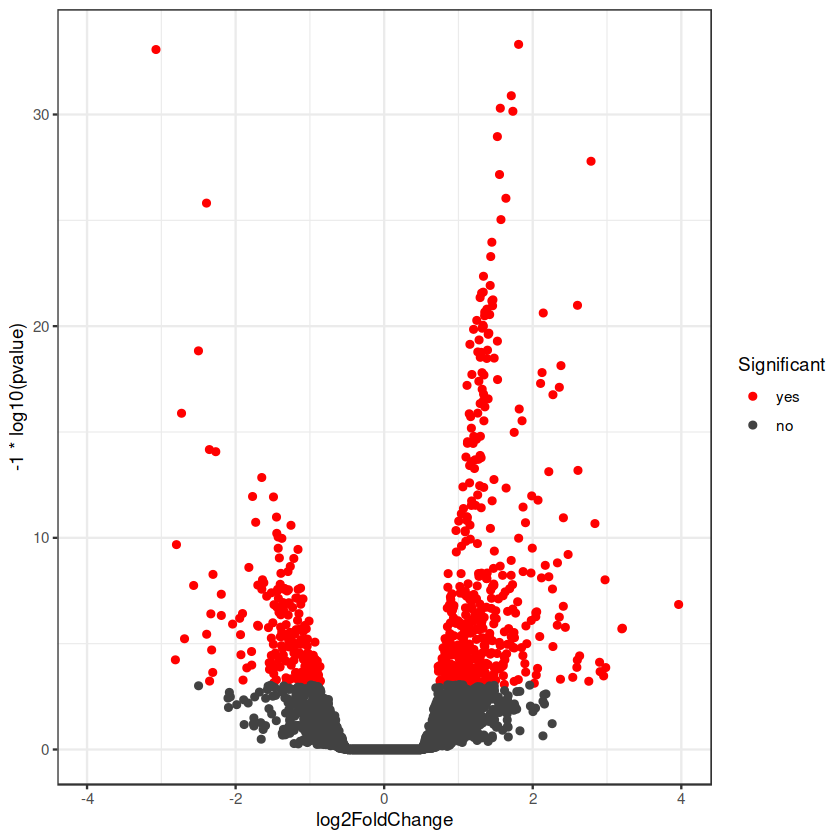

In [15]:
pfi.de.volcano.plot

In [16]:
ggsave(file.path(out.dir, "PFI_DE_volcanoplot.pdf"), plot = pfi.de.volcano.plot , width = 8, height = 10)

Warning message:
“Removed 2 rows containing missing values (geom_point).”


In [17]:
library(ggrepel)

In [18]:
pfi.de.results.selected = pfi.de.results %>% filter(X %in% c("KIF23","AURKA","AURKB", "PTEN"))

In [19]:
annotations.df = data.frame(Gene = pfi.de.results.selected$X,
                            x = pfi.de.results.selected$log2FoldChange,
                            x_end = 0,
                            y = -1 * log10(pfi.de.results.selected$pvalue),
                            y_end = -1 * log10(pfi.de.results.selected$pvalue) + 5)

In [20]:
annotations.df

Gene,x,x_end,y,y_end
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
AURKB,1.4346061,0,23.289266,28.28927
KIF23,1.1223513,0,14.541125,19.54112
AURKA,0.9123786,0,7.357013,12.35701
PTEN,-0.3777877,0,0.000000,5.00000


In [21]:
pfi.de.volcano.plot.with.lab = ggplot(pfi.de.results, aes(x = log2FoldChange, 
                                                 y = -1 * log10(pvalue),
                                                 colour = Significant)) + 
                             geom_point() + 
                             scale_color_manual(values = c("yes" = "red", "no" = "#424242")) +
                             theme_bw() + xlim(-4,4) +
               geom_text(data = annotations.df, aes(x = x_end, y = y_end,label = Gene), colour = "black") +
               geom_segment(data = annotations.df, aes(x = x, xend = x_end, y = y, yend = y_end), colour = "black")

Warning message:
“Removed 2 rows containing missing values (geom_point).”


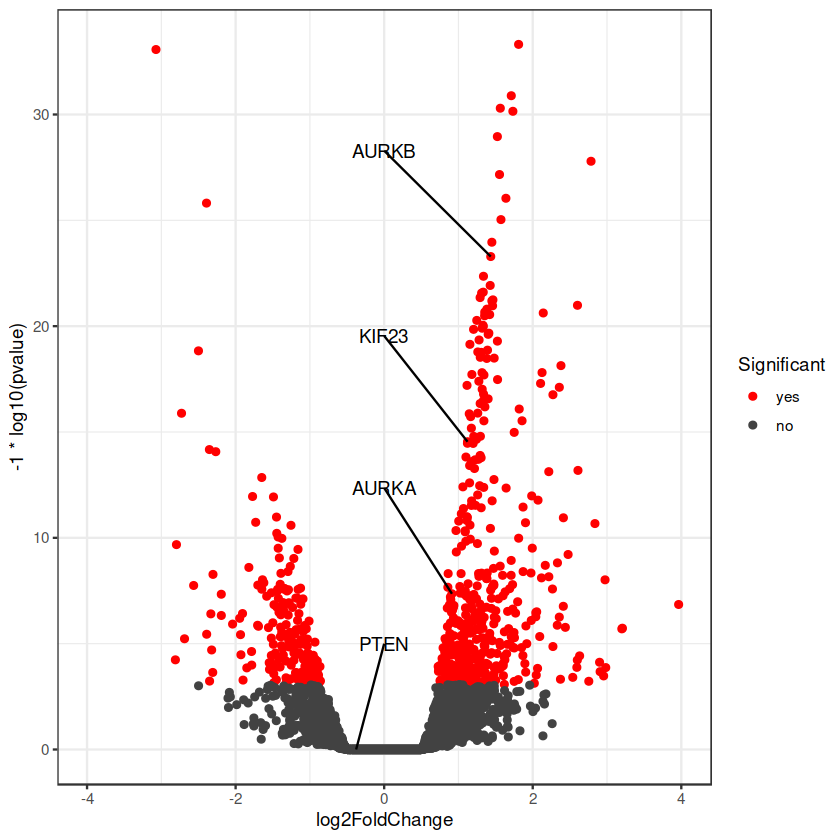

In [22]:
pfi.de.volcano.plot.with.lab 

In [23]:
ggsave(file.path(out.dir, "PFI_DE_volcanoplot_with_lab.pdf"), plot = pfi.de.volcano.plot.with.lab , width = 8, height = 10)

Warning message:
“Removed 2 rows containing missing values (geom_point).”


In [24]:
pfi.de.results.selected.2 = pfi.de.results %>% filter(X %in% c("KIF23","AURKA","AURKB", "PTEN", "BIRC5", "KIF2C", "CDCA8", "TPX2"))

In [25]:
annotations.df = data.frame(Gene = pfi.de.results.selected.2$X,
                            x = pfi.de.results.selected.2$log2FoldChange,
                            x_end = 0,
                            y = -1 * log10(pfi.de.results.selected.2$pvalue),
                            y_end = -1 * log10(pfi.de.results.selected.2$pvalue) + 5)

In [26]:
annotations.df

Gene,x,x_end,y,y_end
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
BIRC5,1.5528328,0,27.164354,32.16435
AURKB,1.4346061,0,23.289266,28.28927
TPX2,1.3523897,0,20.490187,25.49019
KIF2C,1.1807468,0,17.717398,22.71740
KIF23,1.1223513,0,14.541125,19.54112
AURKA,0.9123786,0,7.357013,12.35701
CDCA8,0.8193490,0,5.238248,10.23825
PTEN,-0.3777877,0,0.000000,5.00000


In [27]:
pfi.de.volcano.plot.with.lab.2 = ggplot(pfi.de.results, aes(x = log2FoldChange, 
                                                 y = -1 * log10(pvalue),
                                                 colour = Significant)) + 
                             geom_point() + 
                             scale_color_manual(values = c("yes" = "red", "no" = "#424242")) +
                             theme_bw() + xlim(-4,4) +
               geom_text(data = annotations.df, aes(x = x_end, y = y_end,label = Gene), colour = "black") +
               geom_segment(data = annotations.df, aes(x = x, xend = x_end, y = y, yend = y_end), colour = "black")

Warning message:
“Removed 2 rows containing missing values (geom_point).”


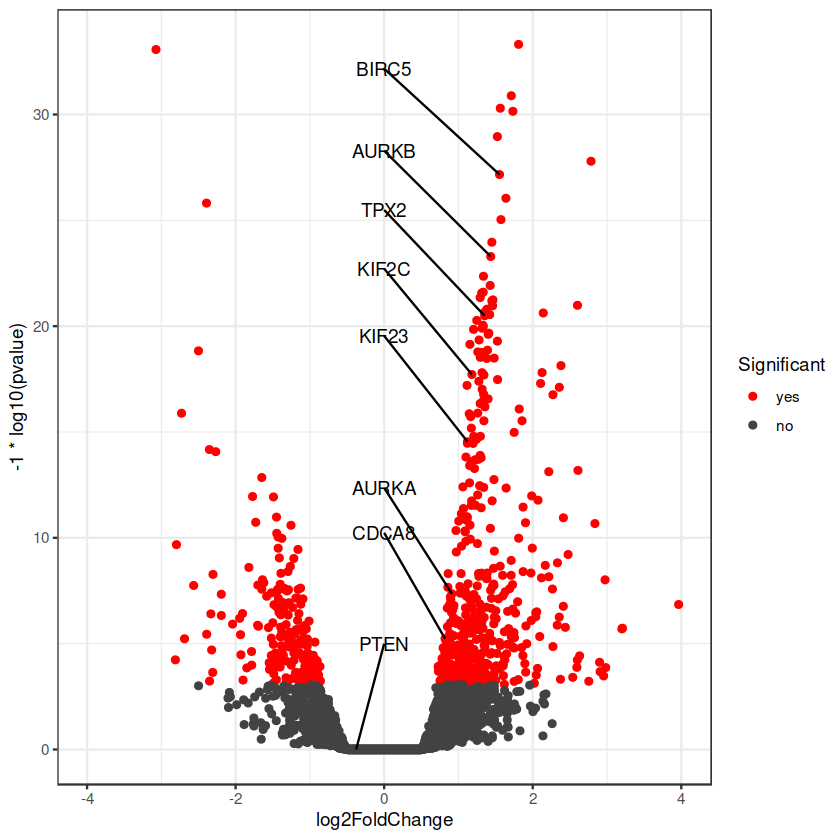

In [28]:
pfi.de.volcano.plot.with.lab.2 

In [29]:
ggsave(file.path(out.dir, "PFI_DE_volcanoplot_with_lab.2.pdf"), plot = pfi.de.volcano.plot.with.lab.2 , width = 8, height = 10)

Warning message:
“Removed 2 rows containing missing values (geom_point).”


In [30]:
# Save volcano input to RDS 
saveRDS(pfi.de.results, file.path(out.dir, "PFI_volcano_input.rds"))

# 7. Pathway enrichment analysis

## 7.1 ORA 

In [32]:
library(clusterProfiler)
library(ReactomePA)



Registered S3 method overwritten by 'ggtree':
  method      from 
  identify.gg ggfun

clusterProfiler v4.2.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:IRanges’:

    slice


The following object is masked from ‘package:S4Vectors’:

    rename


The following object is masked from ‘package:biomaRt’:

    select


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:stats’:

    filter


ReactomePA v1.34.0  For help: https://guangchuangyu.github.io/ReactomePA

If you use ReactomePA in published research, please cite:
Guangchuang Yu, Qing-Yu He.

Functions

In [33]:
#
# Function for converting gene symbols to entrez ids 
#
symbolToEntrez = function(x){
    res = bitr(x, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")
    colnames(res) = c("Feature", "ENTREZID")
    return(res)
}

#
# Function for running Overrepresentation analysis against Reactome database 
#
runORAReactome = function(table){
    
    # Extract the Entrez ids 
    sig.genes = table$ENTREZID
    
    # Run ORA
    enriched.pathways = enrichPathway(gene=sig.genes, 
                                      readable=TRUE)
    # Return full results
    return(enriched.pathways)
    
}

Read in the DE results

In [34]:
# Read 
de.results.tables = map(list.files(path = out.dir, pattern = ".csv", full.names = T) ,read.csv)

# Assign names 
splits = strsplit(list.files(path = out.dir, pattern = ".csv"), "_")
names(de.results.tables) = map_chr(splits, function(x){x[1]})

In [35]:
# Store results
ora.reactome.ls = list()
ora.obj.ls = list()
logFC.ls = list()

In [36]:
for (end.point in names(de.results.tables)){
    
    # DE results
    de.table = de.results.tables[[end.point]]

    # Find significant DE genes 
    diff.genes = de.table %>% 
                    dplyr::filter(padj < 0.05, baseMean >= 20) 

    
    diff.genes.symbol = as.vector(diff.genes$X)
    log.fc = diff.genes$log2FoldChange
    names(log.fc) = diff.genes$X
    logFC.ls[[end.point]] = log.fc
    
    # Map symbols to entrez ids 
    mapped.symbols = symbolToEntrez(diff.genes.symbol)
    
    # Run ORA
    ora.results.obj = runORAReactome(mapped.symbols)
    ora.obj.ls[[end.point]] = ora.results.obj
    ora.results = ora.results.obj@result
    ora.reactome.ls[[end.point]] = ora.results
}

Loading required package: org.Hs.eg.db

Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:clusterProfiler’:

    select


The following object is masked from ‘package:dplyr’:

    select




'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(x, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“7.14% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(x, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“7.14% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(x, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“5.21% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(x, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.e

Write results 

In [37]:
for (end.point in names(ora.reactome.ls)){
    write.csv(ora.reactome.ls[[end.point]], file.path(out.dir, paste0(end.point, "_reactome_pathway_enrichment.csv")))
}

Check TGFbeta genes in the enriched pathways

In [38]:
tgf_beta_genes = read.csv("/workstation//project_data/landstrom_project_3/TGFBeta_genes.csv")

In [39]:
goi = unique(c(tgf_beta_genes$Gene, gene.list))

In [40]:
# TEST if gene in in pathway
geneInPath = function(genes.in.path, goi){
    genes.in.path.ls = unlist(strsplit(genes.in.path, split = "/"))
    common.genes = intersect(genes.in.path.ls, goi)
    if (length(common.genes) > 0){
        return(TRUE)
    } else {
        return(FALSE)
    }
}

In [41]:
pfi.ora.signpathways = ora.reactome.ls$PFI %>% 
                                filter(p.adjust < 0.05)

In [42]:
test = map_lgl(pfi.ora.signpathways$geneID,
       geneInPath,
       goi = goi)

In [43]:
top30.pathways.pfi = pfi.ora.signpathways[1:30,]

In [44]:
top30.pathways.pfi.inc.goi = top30.pathways.pfi[test[1:30],] 

## 7.2 Visualisations 

In [45]:
library(enrichplot)


Attaching package: ‘enrichplot’


The following object is masked from ‘package:ggpubr’:

    color_palette




### 7.2.1 Dotplot

In [46]:
# Save to RDS 
saveRDS(ora.obj.ls[["PFI"]], file.path(out.dir, "PFI_ORA_dotplot_input.rds"))

In [77]:
enrichment.dotplot = dotplot(ora.obj.ls[["PFI"]], showCategory=30)

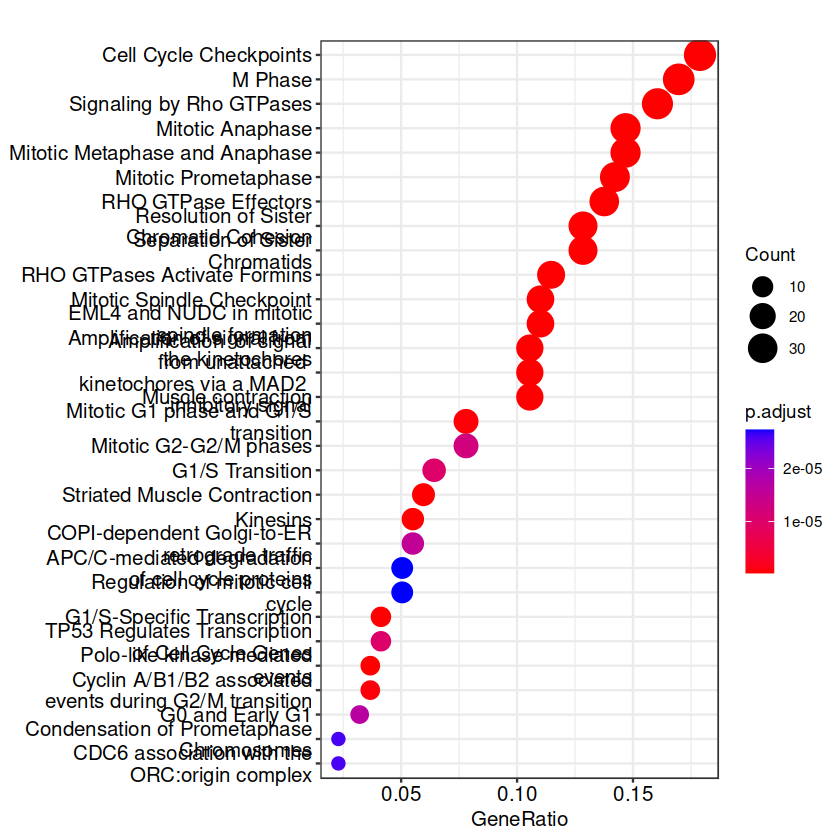

In [78]:
enrichment.dotplot

In [79]:
pdf(file.path(out.dir,"PFI_enrichment_dotplot.pdf"), width = 10, height = 14)
enrichment.dotplot  
dev.off()

png 
  2

### 7.2.2 Enrichment plot

Shows the relatioship of all enriched pathways

In [80]:
ora.obj.ls[["PFI"]] <- pairwise_termsim(ora.obj.ls[["PFI"]])

enrichment.plot <- emapplot(ora.obj.ls[["PFI"]])

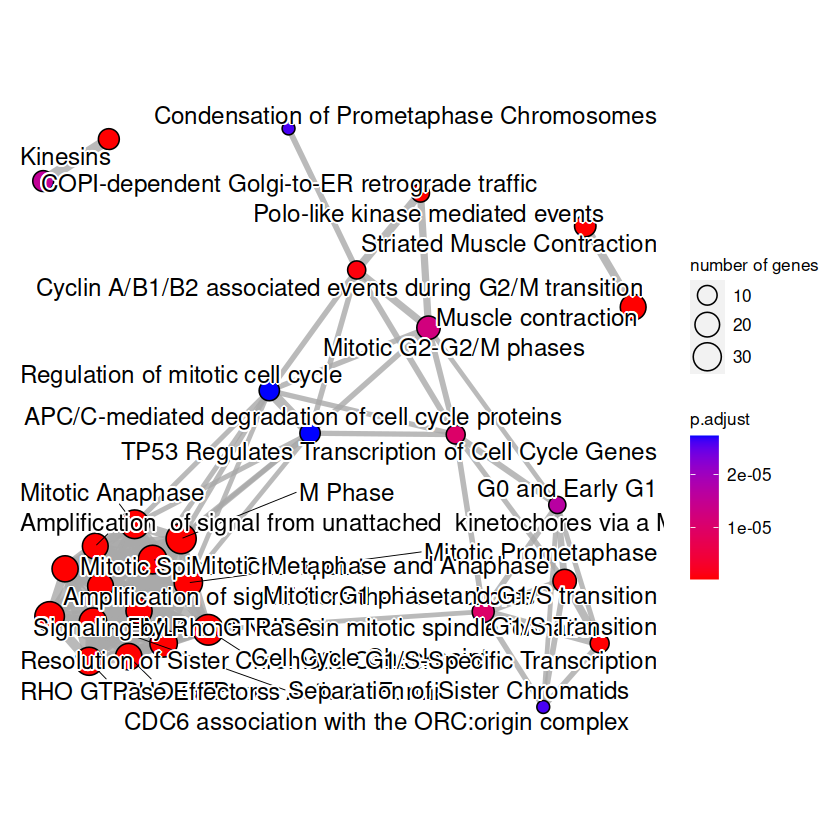

In [81]:
enrichment.plot

In [82]:
pdf(file.path(out.dir,"PFI_enrichment_plot.pdf"), width = 20, height = 20)
enrichment.plot 
dev.off()

png 
  2

Seems that the cell cycle related pathways separate as their own module

### 7.2.3 Cnet plot 

Shows the relatioship between genes and pathways. We will show those pathways in top 30 which also include GOI

In [83]:
ora.obj.ls[["PFI"]] <- setReadable(ora.obj.ls[["PFI"]], 'org.Hs.eg.db', 'ENTREZID')

In [84]:
p1 <- cnetplot(ora.obj.ls[["PFI"]], foldChange=logFC.ls[["PFI"]], 
               showCategory = top30.pathways.pfi.inc.goi$Description)

In [85]:
pdf(file.path(out.dir,"cnet_cell_proliferation_pathways.pdf"), width = 20, height = 20)
p1
dev.off()

png 
  2

Warning message:
“ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 7 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


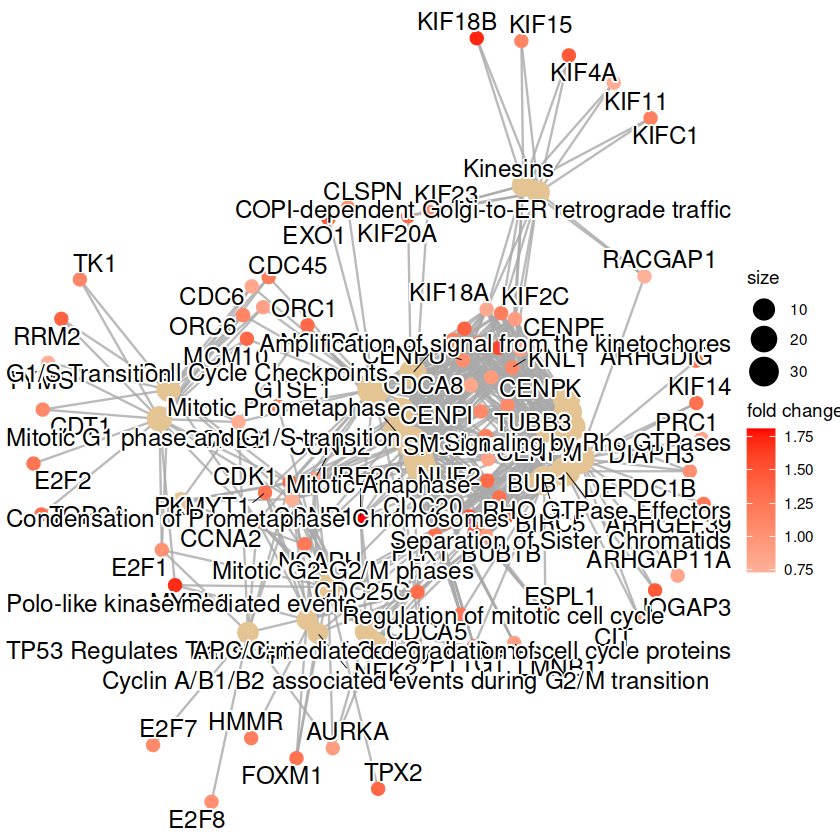

In [86]:
p1

Next we want to produce the same plot but now showing only genes of interest. We include also genes from the "extended list" meining the genes belonging to the non-canonical TGFbeta pathway.

In [87]:
# Read in original gene list 
original.genes = read.table("/workstation/project_data/landstrom_project_3/Customer_genes.tsv", 
                            sep = "\t", header = F)

# Read in pathway genes
tgf_beta_genes = read.csv("/workstation//project_data//landstrom_project_3//TGFBeta_genes.csv")
gene.list = c(tgf_beta_genes$Gene, original.genes$V1)

In [88]:
overlaps = function(x, y){
    genes.pathway = unlist(strsplit(x, "/"))
    intersection = intersect(genes.pathway, y)
    return(intersection)
}

findOverlapsEnr = function(enr.results.df, gene.list){
    res = map(enr.results.df$geneID, overlaps, y = gene.list )
    names(res) = enr.results.df$Description
    return(res)
}

pathway.overlaps = findOverlapsEnr(top30.pathways.pfi.inc.goi, gene.list)

In [89]:
# Find the log-fold changes for these genes 
genes = unique(unlist(pathway.overlaps))
genes.fc = logFC.ls[["PFI"]][genes]

In [90]:
p2 <- cnetplot(pathway.overlaps, foldChange = genes.fc, showCategory = 25)

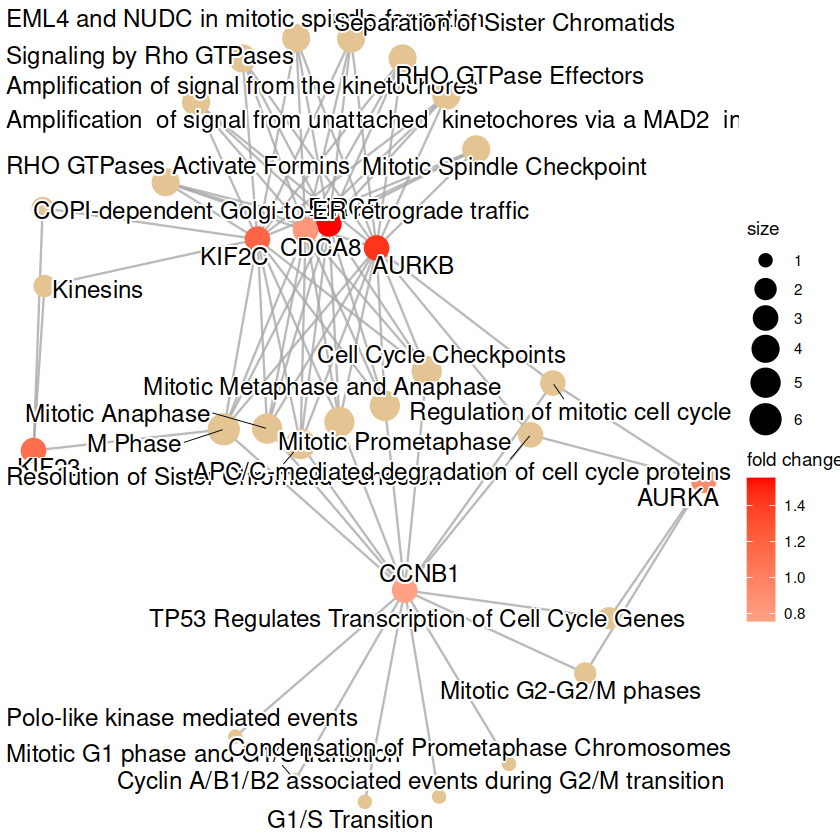

In [91]:
p2

In [92]:
pdf(file.path(out.dir,"cnet_plot_top30_with_goi.pdf"), width = 14, height = 12)
p2
dev.off()

png 
  2

Prepare a version of the above plot only including KIF23, AURKA and AURKB

In [93]:
pathway.overlaps.sig.genes = findOverlapsEnr(top30.pathways.pfi.inc.goi, c("KIF23","AURKA","AURKB"))

In [94]:
length(pathway.overlaps.sig.genes)

[1] 25

In [95]:
genes.fc.sig.genes = logFC.ls[["PFI"]][c("KIF23","AURKA","AURKB")]

In [96]:
genes.fc.sig.genes

KIF23     AURKA     AURKB 
1.1223513 0.9123786 1.4346061

In [97]:
length(pathway.overlaps.sig.genes)

[1] 25

In [98]:
pathway.overlaps.sig.genes.final = list()
pathway.names = c()
idx = 1
for (i in 1:length(pathway.overlaps.sig.genes)){
    name = names(pathway.overlaps.sig.genes)[i]
    item = pathway.overlaps.sig.genes[[i]]

    if (identical(item, character(0)) == F){
        pathway.overlaps.sig.genes.final[[idx]] = item
        pathway.names = c(pathway.names, name)
        idx = idx + 1
    } 
}
names(pathway.overlaps.sig.genes.final) = pathway.names

In [99]:
length(pathway.overlaps.sig.genes.final)

[1] 20

In [100]:
p3 <- cnetplot(pathway.overlaps.sig.genes.final, foldChange = genes.fc.sig.genes, showCategory = 20)

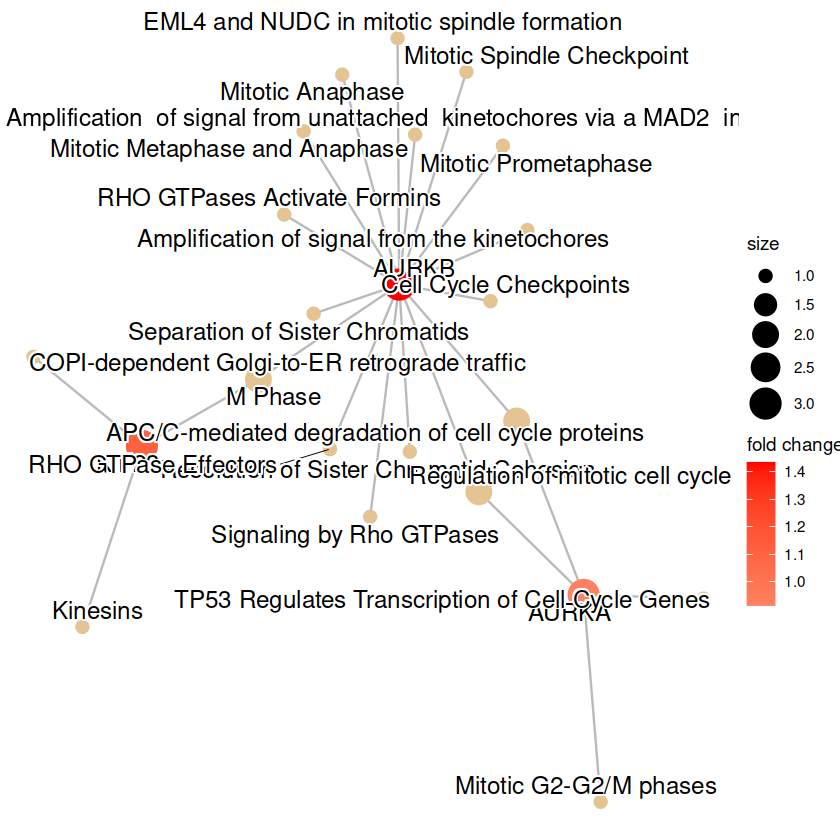

In [101]:
p3

In [102]:
pdf(file.path(out.dir,"cnet_plot_top30_with_KIF23_AURKA_AURKB.pdf"), width = 14, height = 12)
p3
dev.off()

png 
  2

In [103]:
out.dir

[1] "/workstation//project_results/landstrom_core/PRAD_specific_analysis/DE_by_predicted_risk"

### 

### 